In [1]:
import h5py
import pandas as pd
import networkx as nx

In [2]:
metadata = pd.read_csv('DataSet3/data_ALL_clusters.csv')
print(metadata.head())

   clusterID  clusterArea  clusterVolume  clusterTime  clusterSpeed
0        0.0       0.0172       0.001712         0.26      0.650433
1        1.0       0.1252       0.026680         0.76      0.725199
2        2.0       0.0068       0.000704         0.16      0.648554
3        3.0       0.0100       0.000880         0.16      0.512835
4        4.0       0.0560       0.002384         0.14      2.548089


In [3]:
with h5py.File('DataSet3/data_clusters_day_180406.h5', 'r') as f:
    print(list(f.keys()))  # Inspect datasets within

    print(dir(f))



['area', 'array_speed', 'file', 'flag', 'shape', 'speed', 'time', 'volume']
['_MutableMapping__marker', '__abstractmethods__', '__bool__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__setitem__', '__sizeof__', '__slots__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_d', '_e', '_gcpl_crt_order', '_id', '_in_memory_file_counter', '_ipython_key_completions_', '_lapl', '_lcpl', '_libver', 'attrs', 'build_virtual_dataset', 'clear', 'close', 'copy', 'create_dataset', 'create_dataset_like', 'create_group', 'create_virt

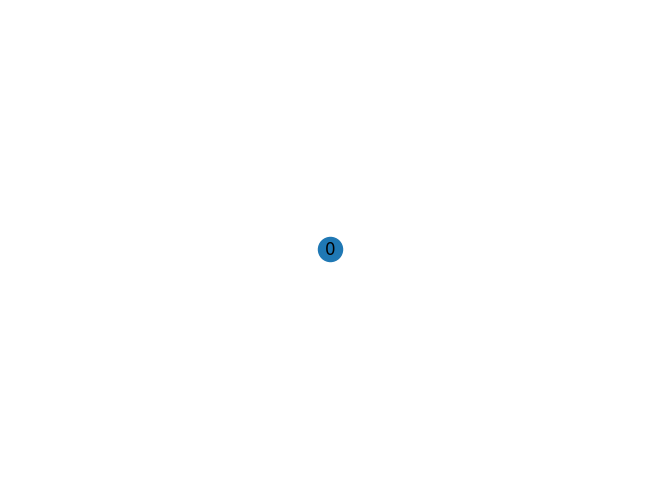

In [4]:

with h5py.File('DataSet3/data_clusters_day_180406.h5', 'r') as f:
    area = f['area'][:]
    speed = f['speed'][:]
    time = f['time'][:]

# Create a graph
G = nx.Graph()

# Add nodes with attributes
for i in range(len(area)):
    G.add_node(i, area=area[i], speed=speed[i], time=time[i])

# Add edges based on proximity (Example: speed similarity)
for i in range(len(area)):
    for j in range(i + 1, len(area)):  # Avoid duplicating edges
        if abs(speed[i] - speed[j]) < 0.5:  # Arbitrary threshold
            G.add_edge(i, j)

# Visualize the graph
nx.draw(G, with_labels=True)

Metadata loaded successfully. First 5 rows:
   clusterID  clusterArea  clusterVolume  clusterTime  clusterSpeed
0        0.0       0.0172       0.001712         0.26      0.650433
1        1.0       0.1252       0.026680         0.76      0.725199
2        2.0       0.0068       0.000704         0.16      0.648554
3        3.0       0.0100       0.000880         0.16      0.512835
4        4.0       0.0560       0.002384         0.14      2.548089

H5 data keys: ['area', 'array_speed', 'file', 'flag', 'shape', 'speed', 'time', 'volume']

Data loaded and scaled successfully.
Error creating fish networks: create_fish_network() got an unexpected keyword argument 'distance_type'

Synthetic networks created successfully.
Tree network: 63 nodes, 62 edges
Closed-loop network: 100 nodes, 200 edges


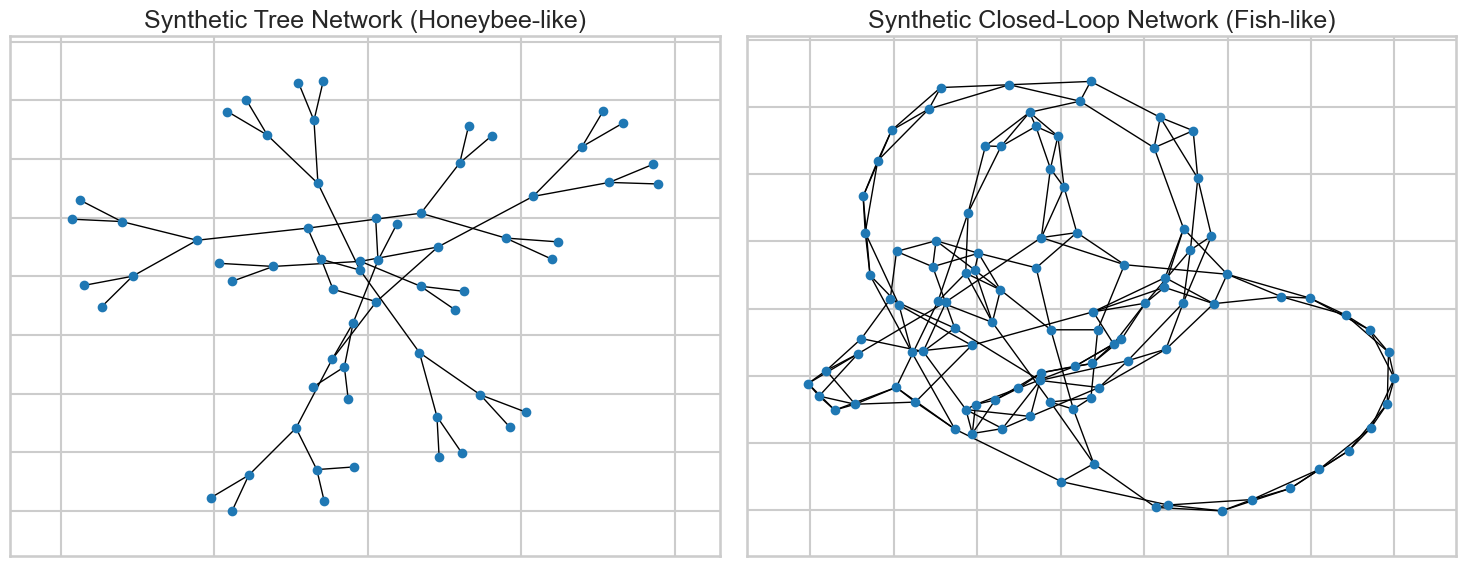

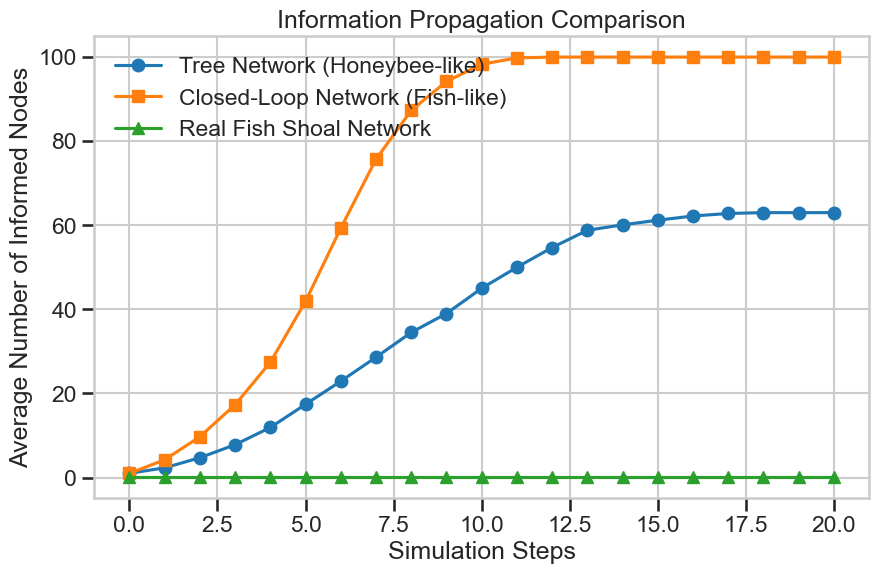

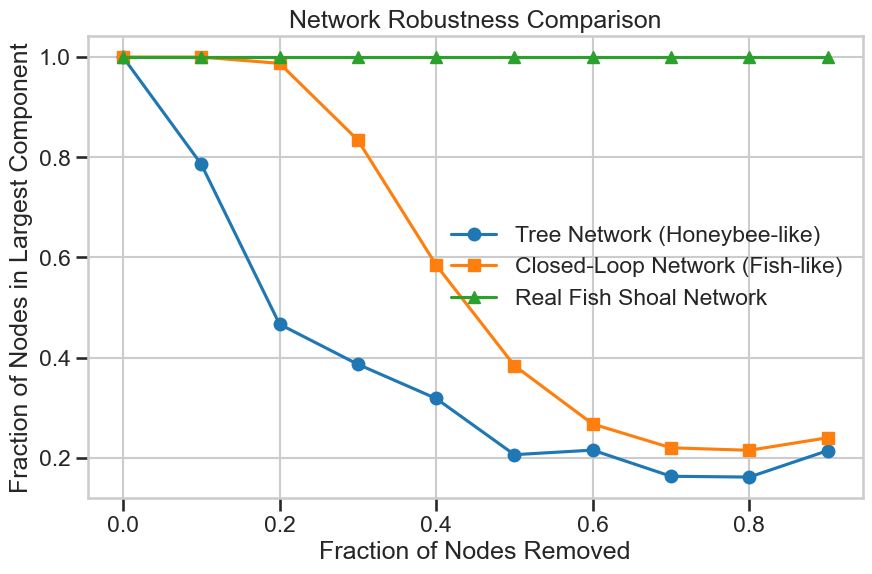

In [10]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
from tqdm import tqdm
import random
from matplotlib.animation import FuncAnimation

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# Function to load data from h5 file
def load_h5_data(filepath):
    data_dict = {}
    with h5py.File(filepath, 'r') as f:
        for key in f.keys():
            data_dict[key] = f[key][:]
    return data_dict

def load_metadata(filepath):
    return pd.read_csv(filepath)

# Load the data
try:
    # Load metadata from CSV
    metadata = load_metadata('DataSet3/data_ALL_clusters.csv')
    print("Metadata loaded successfully. First 5 rows:")
    print(metadata.head())
    
    # Load h5 data
    h5_data = load_h5_data('DataSet3/data_clusters_day_180406.h5')
    print("\nH5 data keys:", list(h5_data.keys()))
    
    # Apply scaling factors as mentioned in the dataset description
    dx = 0.02  # Spatial scaling factor
    dt = 1/50  # Temporal scaling factor
    
    # Scale the data if necessary
    if 'area' in h5_data:
        h5_data['area_scaled'] = h5_data['area'] * dx * dx
    if 'volume' in h5_data:
        h5_data['volume_scaled'] = h5_data['volume'] * dx * dx * dx
    if 'time' in h5_data:
        h5_data['time_scaled'] = h5_data['time'] * dt
    
    print("\nData loaded and scaled successfully.")
except Exception as e:
    print(f"Error loading data: {e}")

def create_fish_network(data, distance_threshold=0.5, connection_type='speed'):

    G = nx.Graph()
    
    # Add node attributes
    for i in range(len(data['area'])):
        G.add_node(i, 
                  area=data['area'][i],
                  speed=data['speed'][i],
                  time=data['time'][i])
    
    # Add edges based on proximity (using the specified attribute)
    for i in range(len(data['area'])):
        for j in range(i + 1, len(data['area'])):
            if connection_type == 'speed':
                distance = abs(data['speed'][i] - data['speed'][j])
            elif connection_type == 'area':
                distance = abs(data['area'][i] - data['area'][j])
            elif connection_type == 'time':
                distance = abs(data['time'][i] - data['time'][j])
            
            if distance < distance_threshold:
                G.add_edge(i, j, weight=1/(distance + 0.01))  # Add a small constant to avoid division by zero
    
    return G

# Create different fish networks using different connection criteria
try:
    fish_network_speed = create_fish_network(h5_data, distance_threshold=1.0, connection_type='speed')
    fish_network_area = create_fish_network(h5_data, distance_threshold=0.1, connection_type='area')
    fish_network_time = create_fish_network(h5_data, distance_type=0.1, connection_type='time')
    
    print("\nFish networks created successfully.")
    print(f"Speed-based network: {fish_network_speed.number_of_nodes()} nodes, {fish_network_speed.number_of_edges()} edges")
    
    # Visualize the speed-based network
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(fish_network_speed, seed=42)
    nx.draw_networkx(fish_network_speed, pos, node_size=50, with_labels=False)
    plt.title("Fish Shoal Network (Speed-Based Connections)")
    plt.show()
except Exception as e:
    print(f"Error creating fish networks: {e}")



def create_tree_network(n_nodes=100, branching_factor=2, max_depth=5):

    # Start with a balanced tree
    T = nx.balanced_tree(branching_factor, max_depth)
    
    # If we have more nodes than required, trim the graph
    while T.number_of_nodes() > n_nodes:
        leaf_nodes = [node for node, degree in T.degree() if degree == 1]
        if leaf_nodes:
            T.remove_node(random.choice(leaf_nodes))
        else:
            break
    
    # Add some attributes to nodes
    for node in T.nodes():
        T.nodes[node]['importance'] = random.uniform(0, 1)
        T.nodes[node]['response_time'] = random.uniform(0.1, 1.0)
    
    return T

def create_closed_loop_network(n_nodes=100, k=4, p=0.1):
    # Create a small-world network (Watts-Strogatz model)
    C = nx.watts_strogatz_graph(n_nodes, k, p)
    
    # Add some attributes to nodes
    for node in C.nodes():
        C.nodes[node]['importance'] = random.uniform(0, 1)
        C.nodes[node]['response_time'] = random.uniform(0.1, 1.0)
    
    return C

# Create synthetic networks
tree_network = create_tree_network(n_nodes=100)
closed_loop_network = create_closed_loop_network(n_nodes=100)

print("\nSynthetic networks created successfully.")
print(f"Tree network: {tree_network.number_of_nodes()} nodes, {tree_network.number_of_edges()} edges")
print(f"Closed-loop network: {closed_loop_network.number_of_nodes()} nodes, {closed_loop_network.number_of_edges()} edges")

# Visualize both synthetic networks
plt.figure(figsize=(15, 6))

plt.subplot(121)
pos_tree = nx.spring_layout(tree_network, seed=42)
nx.draw_networkx(tree_network, pos_tree, node_size=30, with_labels=False)
plt.title("Synthetic Tree Network (Honeybee-like)")

plt.subplot(122)
pos_loop = nx.spring_layout(closed_loop_network, seed=42)
nx.draw_networkx(closed_loop_network, pos_loop, node_size=30, with_labels=False)
plt.title("Synthetic Closed-Loop Network (Fish-like)")

plt.tight_layout()
plt.show()


def simulate_information_propagation(G, start_node, p_transmit=0.8, steps=20):

    # Initialize nodes
    informed_nodes = {start_node}
    informed_nodes_history = [informed_nodes.copy()]
    
    # Run simulation for the specified number of steps
    for _ in range(steps):
        newly_informed = set()
        
        # For each already informed node
        for node in informed_nodes:
            # Try to spread information to neighbors
            for neighbor in G.neighbors(node):
                if neighbor not in informed_nodes and random.random() < p_transmit:
                    newly_informed.add(neighbor)
        
        # Update the set of informed nodes
        informed_nodes.update(newly_informed)
        informed_nodes_history.append(informed_nodes.copy())
    
    return informed_nodes_history

def calculate_metrics(G, propagation_history):

    metrics = {}
    
    # Speed: Average number of newly informed nodes per step
    speeds = [len(propagation_history[i]) - len(propagation_history[i-1]) 
              for i in range(1, len(propagation_history))]
    metrics['avg_speed'] = np.mean(speeds)
    
    # Coverage: Fraction of nodes informed at the end
    metrics['coverage'] = len(propagation_history[-1]) / G.number_of_nodes()
    
    # Time to reach 50% coverage (if achieved)
    half_nodes = G.number_of_nodes() / 2
    for i, informed in enumerate(propagation_history):
        if len(informed) >= half_nodes:
            metrics['time_to_half'] = i
            break
    else:
        metrics['time_to_half'] = float('inf')
    
    return metrics

# Run simulations on all networks
def run_multiple_simulations(G, num_simulations=10, steps=20):
    all_histories = []
    start_nodes = random.sample(list(G.nodes()), min(num_simulations, G.number_of_nodes()))
    
    for start_node in start_nodes:
        history = simulate_information_propagation(G, start_node, steps=steps)
        all_histories.append(history)
    
    # Calculate average informed nodes at each step
    avg_informed = []
    for step in range(steps + 1):
        total_informed = sum(len(history[step]) for history in all_histories)
        avg_informed.append(total_informed / num_simulations)
    
    return avg_informed

# Run simulations
tree_results = run_multiple_simulations(tree_network)
closed_loop_results = run_multiple_simulations(closed_loop_network)

# If fish network was created successfully, run simulation on it too
fish_results = None
try:
    if 'fish_network_speed' in locals():
        fish_results = run_multiple_simulations(fish_network_speed)
except Exception as e:
    print(f"Error running simulations on fish network: {e}")

# Plot the results
plt.figure(figsize=(10, 6))
steps = range(len(tree_results))
plt.plot(steps, tree_results, 'o-', label='Tree Network (Honeybee-like)')
plt.plot(steps, closed_loop_results, 's-', label='Closed-Loop Network (Fish-like)')

if fish_results:
    plt.plot(steps, fish_results, '^-', label='Real Fish Shoal Network')

plt.xlabel('Simulation Steps')
plt.ylabel('Average Number of Informed Nodes')
plt.title('Information Propagation Comparison')
plt.legend()
plt.grid(True)
plt.show()


def test_robustness(G, failure_fractions, num_trials=10):

    results = {fraction: [] for fraction in failure_fractions}
    
    for fraction in failure_fractions:
        for _ in range(num_trials):
            G_copy = G.copy()
            n_remove = int(fraction * G.number_of_nodes())
            nodes_to_remove = random.sample(list(G_copy.nodes()), n_remove)            
            G_copy.remove_nodes_from(nodes_to_remove)
            
            # get the size of largest connected component
            if G_copy.number_of_nodes() > 0:
                largest_cc = max(nx.connected_components(G_copy), key=len)
                largest_cc_size = len(largest_cc) / (G.number_of_nodes() - n_remove)
            else:
                largest_cc_size = 0
            
            results[fraction].append(largest_cc_size)
    
    avg_results = {fraction: np.mean(sizes) for fraction, sizes in results.items()}
    
    return avg_results

# Define fractions of nodes to remove
failure_fractions = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Test robustness
tree_robustness = test_robustness(tree_network, failure_fractions)
closed_loop_robustness = test_robustness(closed_loop_network, failure_fractions)

# If fish network was created successfully, test its robustness too
fish_robustness = None
try:
    if 'fish_network_speed' in locals():
        fish_robustness = test_robustness(fish_network_speed, failure_fractions)
except Exception as e:
    print(f"Error testing robustness on fish network: {e}")

# Plot robustness results
plt.figure(figsize=(10, 6))
plt.plot(list(tree_robustness.keys()), list(tree_robustness.values()), 'o-', label='Tree Network (Honeybee-like)')
plt.plot(list(closed_loop_robustness.keys()), list(closed_loop_robustness.values()), 's-', label='Closed-Loop Network (Fish-like)')

if fish_robustness:
    plt.plot(list(fish_robustness.keys()), list(fish_robustness.values()), '^-', label='Real Fish Shoal Network')

plt.xlabel('Fraction of Nodes Removed')
plt.ylabel('Fraction of Nodes in Largest Component')
plt.title('Network Robustness Comparison')
plt.legend()
plt.grid(True)
plt.show()


def create_information_propagation_animation(G, pos, start_node):
    """Create an animation of information propagation through a network."""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Initialize with all nodes blue (uninformed)
    nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax)
    nodes = nx.draw_networkx_nodes(G, pos, node_color='blue', ax=ax)
    
    # Set node at start_node to red (informed)
    informed_nodes = {start_node}
    
    def update(frame):
        # information
        newly_informed = set()
        for node in informed_nodes:
            for neighbor in G.neighbors(node):
                if neighbor not in informed_nodes and random.random() < 0.3:  # 30% chance to transmit
                    newly_informed.add(neighbor)
        
        informed_nodes.update(newly_informed)
        
        # colors
        node_colors = ['red' if node in informed_nodes else 'blue' for node in G.nodes()]
        nodes.set_color(node_colors)
        
        return nodes,
    
    # animation
    ani = FuncAnimation(fig, update, frames=20, interval=500, blit=True)
    plt.title("Information Propagation Simulation")
    plt.close() 
    
    return ani, fig

tree_ani, tree_fig = create_information_propagation_animation(tree_network, pos_tree, list(tree_network.nodes())[0])
closed_loop_ani, closed_loop_fig = create_information_propagation_animation(closed_loop_network, pos_loop, list(closed_loop_network.nodes())[0])

tree_ani.save('tree_propagation.gif', writer='pillow', fps=2)
closed_loop_ani.save('closed_loop_propagation.gif', writer='pillow', fps=2)